## VAE Results

In [106]:
import pandas as pd
import torch
import sys
import os
from PIL import Image
from torchvision import transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sys.path.append('/home/juandres/aml/CheXBias/src/')
from general_functions import *
import scipy.stats

### Import model

In [2]:
# Set the target GPU
device = torch.device('cuda:1')

# Move the entire process to the specified GPU
torch.cuda.set_device(device)

# Instantiate the VAE
vae = AdaptableVAE(input_channels=1, latent_size=2*64, input_size=224).to(device)

# Load pre-trained weights
vae.load_state_dict(torch.load('/home/juandres/aml/CheXBias/models/VAE/test4.pth', map_location={'cuda:0': 'cuda:1'}))


<All keys matched successfully>

### Load sample images


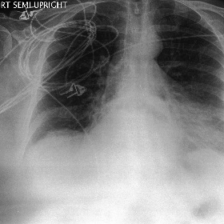

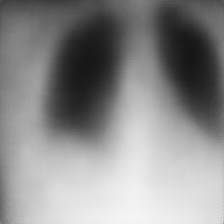

In [6]:
# List all test images
path_test = '/home/juandres/aml/CheXBias/data_new/processed/test'
images = os.listdir(path_test)

# Load single image
img = Image.open(os.path.join(path_test,images[201])).convert('L')  # 'L' mode for grayscale
# Define pre-process
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),  # Convert grayscale to specified number of channels
    transforms.ToTensor()
    ])
img = preprocess(img)
display(transforms.ToPILImage()(img))
vae_output = vae(img.unsqueeze(1).to(device))
img_reconstructed = vae_output[0].squeeze(0)
transforms.ToPILImage()(img_reconstructed[0].cpu())

### Create Joint histogram for each latent variable 

In [231]:
# Load mean for each one of the latent features per image
latent_mean_df = pd.read_csv('/home/juandres/aml/CheXBias/reports/VAE/test4.csv')
latent_mean = latent_mean_df[latent_mean_df.columns[1:]].to_numpy()

In [232]:
# Iterate over all latent features

# Save again the latent_mean_pro
latent_mean_prob = []

for i in range(0,latent_mean.shape[1]):

    # Get all the mean values for this latent features
    latent_mean_tmp = latent_mean[:,i]

    # Get mean and std of the distribution
    mean_latent = latent_mean_tmp.mean()
    std_latent = latent_mean_tmp.std()

    # Get a probability value for each sample in the latent features
    latent_prob = scipy.stats.norm.pdf(latent_mean_tmp, loc=mean_latent, scale=std_latent)

    latent_mean_prob.append(latent_prob)

latent_mean_prob_array = np.stack(latent_mean_prob,axis=1)

In [233]:
SumProb = pd.DataFrame(latent_mean_prob_array.sum(axis=1),index=latent_mean_df['file_name'],columns=['SumProb'])
SumProb = SumProb.sort_values(by='SumProb',ascending=False)

In [282]:
# First 10 images
top_images = SumProb.head(10).reset_index()
bottom_images = SumProb.tail(10).reset_index()

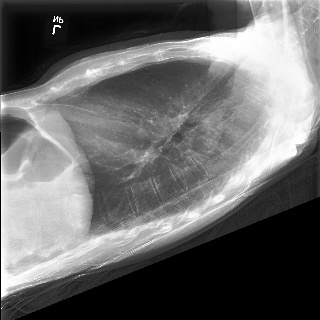

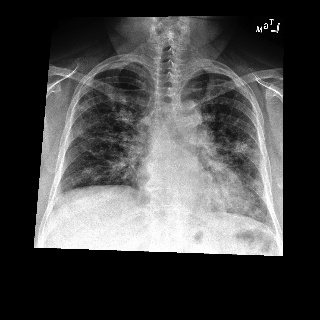

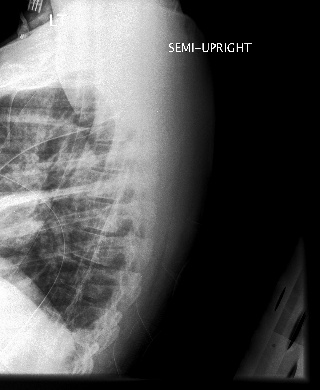

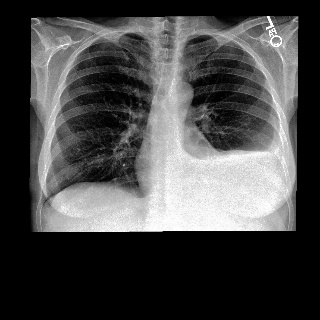

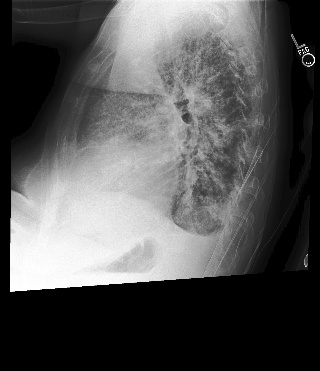

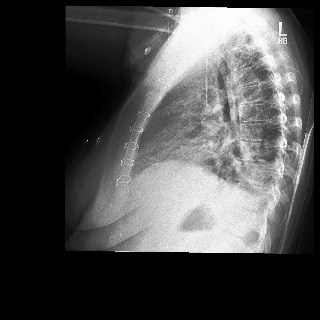

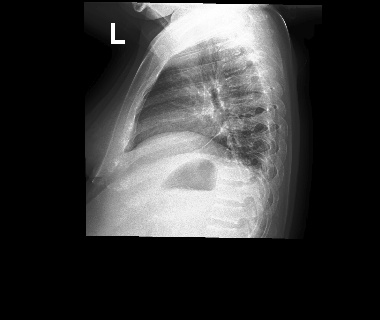

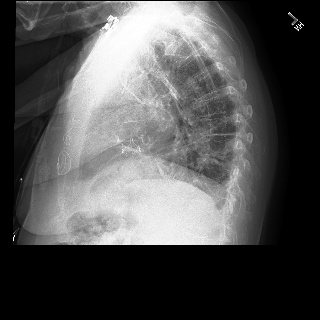

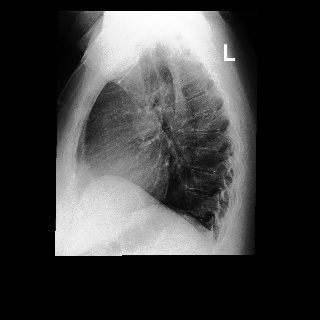

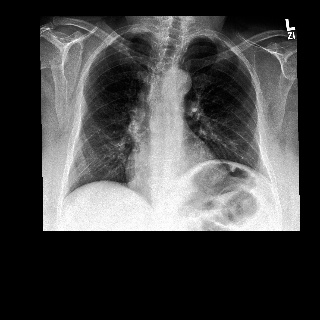

In [286]:
# Show Images for both cases
for image in bottom_images['file_name']:
    img = Image.open(os.path.join('/home/juandres/aml/CheXBias/data_new/processed/train',image)).convert('L')
    display(img)

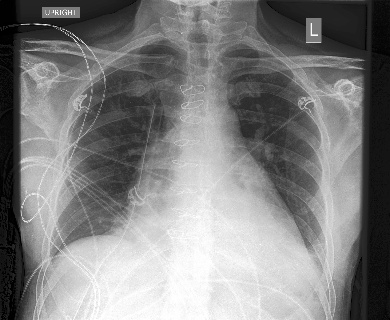

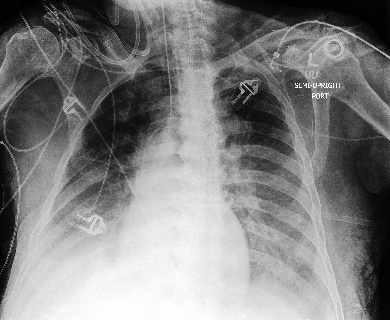

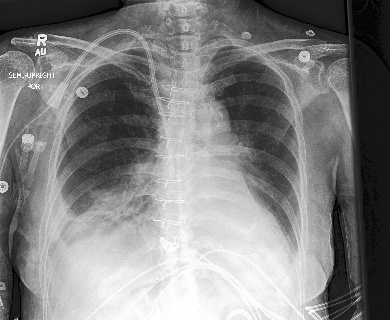

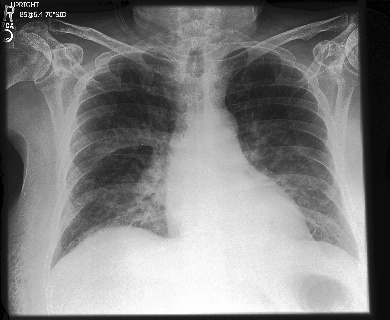

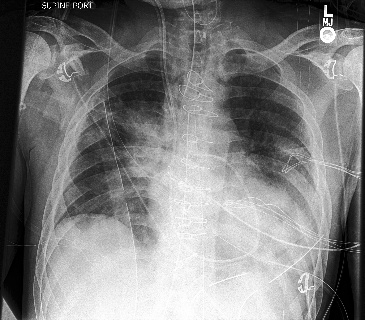

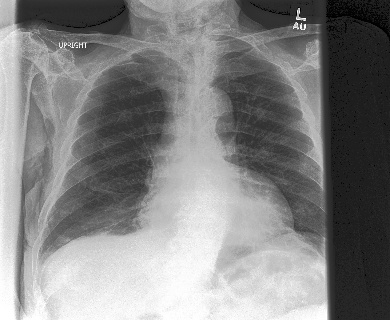

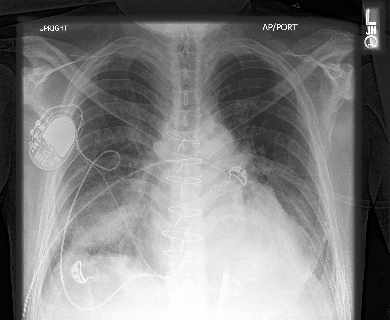

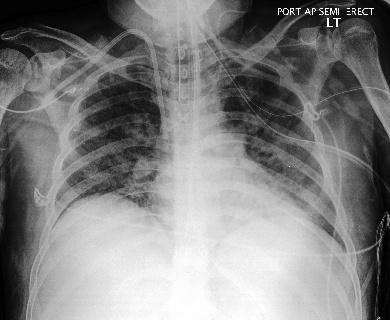

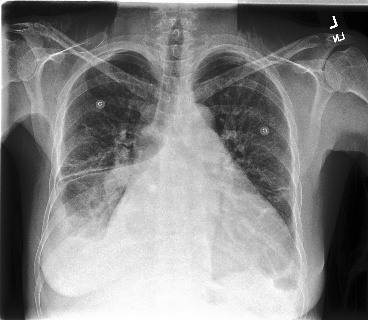

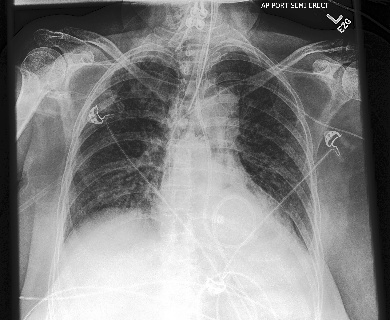

In [288]:
# Show Images for both cases
for image in top_images['file_name']:
    img = Image.open(os.path.join('/home/juandres/aml/CheXBias/data_new/processed/train',image)).convert('L')
    display(img)

In [284]:
xx = [el.split('_')[4] for el in bottom_images['file_name']]
yy = [el.split('_')[4] for el in top_images['file_name']]

print('Bottom')
display(pd.DataFrame(xx).value_counts())
print('Top')
display(pd.DataFrame(yy).value_counts())

Bottom


Female    10
Name: count, dtype: int64

Top


Male      7
Female    3
Name: count, dtype: int64

In [285]:
xx = [el.split('_')[5] for el in bottom_images['file_name']]
yy = [el.split('_')[5] for el in top_images['file_name']]

print('Bottom')
print(np.array(xx).astype(int).mean())
print(np.array(xx).astype(int).std())
print('Top')
print(np.array(yy).astype(int).mean())
print(np.array(yy).astype(int).std())

Bottom
54.1
16.711971756797578
Top
55.8
15.432433379088343


In [266]:
print('Bottom')
display(pd.DataFrame(xx).value_counts())
print('Top')
display(pd.DataFrame(yy).value_counts())

Bottom


Male      28
Female    22
Name: count, dtype: int64

Top


Male      30
Female    20
Name: count, dtype: int64

### Other stuff

<Axes: >

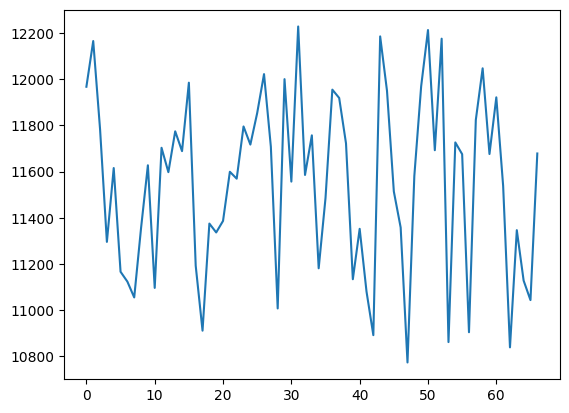

In [38]:
import matplotlib.pyplot as plt
df = pd.read_csv('/home/juandres/aml/CheXBias/reports/VAE/mse_loss.csv')
df[df.columns[2]].plot()